In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
file = "data/output_with_sentiment.csv"
df = pd.read_csv(file)

In [3]:
df = df[["index",
    "text",
    "kontext",
    "klassifikation.tore_bayern",
    "klassifikation.tore_gegner",
    "klassifikation.phase",
    "meta.saison",
    "meta.spieltag",
    "meta.heim_auswaerts",
    "meta.gegner",
    "meta.tabelle",
    "meta.ballbesitz_bayern",
    "ergebnis.bayern",
    "ergebnis.gegner",
    "offizielle.schiedsrichter",
    "offizielle.kommentator",
    "source_file",
    "sentiment__fine_tuned_german_sentiment",
    "sentiment__fine_tuned_german_sentiment__conf"
]]

In [4]:
mapping = {'Positiv': 1, 'Negativ': -1, 'Neutral': 0}
df['sentiment_numeric'] = df['sentiment__fine_tuned_german_sentiment'].map(mapping)

In [5]:
df['weighted_sentiment'] = (
    df['sentiment_numeric'] * df['sentiment__fine_tuned_german_sentiment__conf']
)

In [6]:
# 1) Kontext klarstellen (nur falls noch nicht sauber definiert)
df['kontext_group'] = df['kontext'].apply(
    lambda x: 'FC Bayern München' if str(x).strip() == 'FC Bayern München' else 'Gegner'
)

# 2) Zeilen pro Spiel und Kontext zählen
row_counts = (
    df.groupby(['source_file', 'kontext_group'], as_index=False)
      .size()
      .rename(columns={'size': 'row.count'})
)

# 3) Pivot -> Bayern / Gegner nebeneinander
row_counts_pivot = (
    row_counts.pivot(
        index='source_file',
        columns='kontext_group',
        values='row.count'
    )
    .reset_index()
)
row_counts_pivot.columns.name = None

# 4) Umbenennen
row_counts_pivot = row_counts_pivot.rename(columns={
    'FC Bayern München': 'rows.bayern',
    'Gegner': 'rows.gegner'
})

# 5) Prozentanteile berechnen
row_counts_pivot['rows.total'] = row_counts_pivot['rows.bayern'] + row_counts_pivot['rows.gegner']
row_counts_pivot['bayern.percent'] = row_counts_pivot['rows.bayern'] / row_counts_pivot['rows.total']
row_counts_pivot['gegner.percent'] = row_counts_pivot['rows.gegner'] / row_counts_pivot['rows.total']
row_counts_pivot[['bayern.percent', 'gegner.percent']] = row_counts_pivot[['bayern.percent', 'gegner.percent']].round(2)

# 6) Ballbesitz pro Spiel holen (angenommen numerisch für Bayern)
ballbesitz = (
    df.groupby('source_file', as_index=False)['meta.ballbesitz_bayern']
      .mean()  # falls pro Zeile wiederholt; nutzt den Mittelwert/identischen Wert
)

# 7) Tordifferenz pro Spiel berechnen
tordiff = (
    df.groupby('source_file', as_index=False)
      .agg({
          'ergebnis.bayern': 'first',
          'ergebnis.gegner': 'first'
      })
)
tordiff['ergebnis.tordifferenz'] = tordiff['ergebnis.bayern'] - tordiff['ergebnis.gegner']

# 8) Alles zusammenführen
out = (
    row_counts_pivot
    .merge(ballbesitz, on='source_file', how='left')
    .merge(tordiff[['source_file', 'ergebnis.tordifferenz']], on='source_file', how='left')
)

# 9) Finale Ansicht
out = out[['source_file', 'bayern.percent', 'gegner.percent', 'meta.ballbesitz_bayern', 'ergebnis.tordifferenz']] \
         .sort_values('bayern.percent', ascending=False)

out

,source_file,bayern.percent,gegner.percent,meta.ballbesitz_bayern,ergebnis.tordifferenz
5,23-24_S15_vfb_stuttgart.json,0.72,0.28,0.61,3
59,24-25_S33_borussia_mönchengladbach.json,0.69,0.31,0.62,2
60,24-25_S34_tsg_hoffenheim.json,0.67,0.33,0.66,4
33,23-24_S9_sv_darmstadt_98.json,0.66,0.34,0.54,8
46,24-25_S21_sv_werder_bremen.json,0.65,0.35,0.75,3
...,...,...,...,...,...
63,24-25_S5_bayer_04_leverkusen.json,0.33,0.67,0.69,0
32,23-24_S8_fsv_mainz_05.json,0.32,0.68,0.62,2
13,23-24_S22_vfl_bochum.json,0.31,0.69,0.68,-1
12,23-24_S21_bayer_04_leverkusen.json,0.29,0.71,0.61,-3


In [7]:
# Pearson Correlation
corr = out['bayern.percent'].corr(out['meta.ballbesitz_bayern'])
print(f"Korrelation (Pearson): {corr:.3f}")

# |r| < 0.3 → schwach
# 0.3 ≤ |r| < 0.7 → moderat
# |r| ≥ 0.7 → stark

Korrelation (Pearson): 0.258


In [8]:
corr_tordiff = out['bayern.percent'].corr(out['ergebnis.tordifferenz'])
print(f"Korrelation (Tordifferenz ↔ Redeanteil Bayern): {corr_tordiff:.3f}")

Korrelation (Tordifferenz ↔ Redeanteil Bayern): 0.541


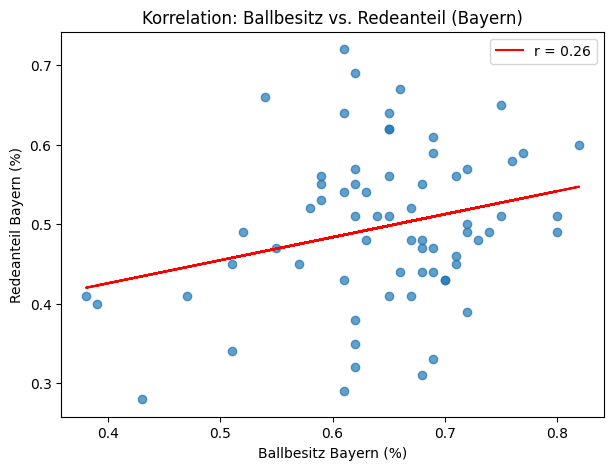

In [ ]:
x = out['meta.ballbesitz_bayern']
y = out['bayern.percent']

plt.figure(figsize=(7, 5))
plt.scatter(x, y, alpha=0.7)
m, b = np.polyfit(x, y, 1)  # lineare Regression
plt.plot(x, m*x + b, color='red', label=f"r = {y.corr(x):.2f}")
plt.xlabel("Ballbesitz Bayern (%)")
plt.ylabel("Redeanteil Bayern (%)")
plt.title("Korrelation: Ballbesitz vs. Redeanteil (Bayern)")
plt.legend()

file_prefix = "data/results"
filename = "korrelation_ballbesitz"
plt.savefig(f'{file_prefix}/grafiken_png/{filename}.png')
plt.savefig(f'{file_prefix}/grafiken_pdf/{filename}.pdf')

plt.show()

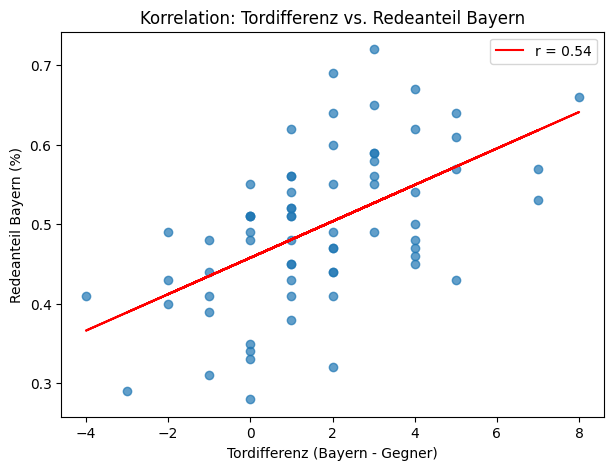

In [ ]:
x = out['ergebnis.tordifferenz']
y = out['bayern.percent']

plt.figure(figsize=(7,5))
plt.scatter(x, y, alpha=0.7)
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, color='red', label=f"r = {y.corr(x):.2f}")
plt.xlabel("Tordifferenz (Bayern - Gegner)")
plt.ylabel("Redeanteil Bayern (%)")
plt.title("Korrelation: Tordifferenz vs. Redeanteil Bayern")
plt.legend()

file_prefix = "data/results"
filename = "korrelation_tordifferenz"
plt.savefig(f'{file_prefix}/grafiken_png/{filename}.png')
plt.savefig(f'{file_prefix}/grafiken_pdf/{filename}.pdf')

plt.show()